In [72]:
%pip install arm-mango

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install torch
%pip install torch_geometric

In [1]:
from mango import Tuner
import tqdm

In [2]:
import sys
import os
module_dir = os.path.abspath("/lustrehome/federicacuna/TB_Sept_2023_ml/Code/Pytorch_gnn/")
sys.path.append(module_dir)

In [3]:
import pandas as pd
import torch
import torch_geometric
from torch_geometric.data import Dataset, Data
import numpy as np 
import time
from torch_geometric.loader import DataLoader
import os
from torch_geometric.nn import Sequential, GCNConv,GATConv
import matplotlib.pyplot as plt
from torch.nn import Linear
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, accuracy_score
import time
import MyData as data
import itertools
import seaborn as sns

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
import GNN_model

In [4]:
class GCN(torch.nn.Module):
    # def __init__(self, hidden_size, num_ly, num_feat, num_class,num_to_reduce):
    def __init__(self, num_feat, hidden_size,num_class, model_params):
        super().__init__()
        num_ly_val = model_params["model_num_ly"]
        num_to_reduce=model_params["model_num_toreduce"]
        aggr=model_params["model_aggr"]
        for num_ly in range( num_ly_val):
            if(hidden_size - (num_ly - 1) * num_ly==0):
                print('not proper number of ly and hidden size')
                num_ly=int(hidden_size/num)
                print(f' the number of layer will be set to: {num_ly}')
            
            # return
        # Model layers
        self.num_ly = num_ly
        self.conv_layers = torch.nn.ModuleList()
        
        self.conv_layers.append(GCNConv(num_feat, hidden_size,aggr))
        
        for i in range(1, num_ly):
            current_hidden_size = hidden_size - i * num_to_reduce
            prev_hidden_size = hidden_size - (i - 1) * num_to_reduce
            self.conv_layers.append(GCNConv(prev_hidden_size, current_hidden_size,aggr))

        self.conv_layers.append(GCNConv(hidden_size - (num_ly - 1) * num_to_reduce, num_class))

    def forward(self, data):
    
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        for conv in self.conv_layers[:-1]:
            x = conv(x, edge_index)
            x = F.tanh(x)
            # x = F.relu(x)
        
        x = self.conv_layers[-1](x, edge_index)
        
        return F.sigmoid(x)



In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
print('Using device:', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda
NVIDIA A100-PCIE-40GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [78]:
# %%time
# NUM_FEATURES = train_dataset[0].x.shape[1]
# print(NUM_FEATURES)
# NUM_CLASSES =1


In [6]:
def train_one_epoch(epoch, model, train_loader, optimizer, loss_fn):
    # Enumerate over the data
    all_preds = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for batch in train_loader:
        # Use GPU
        batch.to(device)  
        # Reset gradients
        optimizer.zero_grad() 
        model_output=model(batch)
        # Passing the node features and the connection info
        pred = torch.where(model_output > 0.8, 1, 0)
        # Calculating the loss and gradients
        labels=batch.y.float().to(device)
        loss = loss_fn(model_output.squeeze(1).float(), labels)  # Compute the loss.

        # loss = criterion(out.squeeze(1).float(), labels)
        loss.backward()  
        optimizer.step()  
        # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
        all_labels.append(batch.y.cpu().detach().numpy())
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "train")
    return running_loss/step

In [7]:
def test(epoch, model, test_loader, loss_fn):
    all_preds = []
    all_preds_raw = []
    all_labels = []
    running_loss = 0.0
    step = 0
    for batch in test_loader:
        batch.to(device)  
        model_output=model(batch)
        pred = torch.where(model_output > 0.8, 1, 0)
        # pred = model(batch.x.float(), 
        #                 batch.edge_index, 
        #                 batch.batch) 
        # loss = loss_fn(torch.squeeze(pred), batch.y.long().to(device))
        
        labels=batch.y.float().to(device)
        loss = loss_fn(model_output.squeeze(1).float(), labels)  # Compute the loss.


         # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds.append(np.rint(torch.sigmoid(pred).cpu().detach().numpy()))
        all_preds_raw.append(torch.sigmoid(pred).cpu().detach().numpy())
        all_labels.append(batch.y.cpu().detach().numpy())
    
    all_preds = np.concatenate(all_preds).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    calculate_metrics(all_preds, all_labels, epoch, "test")
    # log_conf_matrix(all_preds, all_labels, epoch)
    return running_loss/step

In [8]:
from mango import scheduler

def run_one_training(params):
    params = params[0]
    

    data_handler=data.dataset_preparation(root='/lustrehome/federicacuna/TB_Sept_2023_ml/Data/preprocessed')
    fnamex='pi-_10GeV_4ly_1e-4ly_normalized_1e-4_viewx'
    fnamey='pi-_10GeV_4ly_1e-4ly_normalized_1e-4_viewy'
    data_trk=data_handler.get_more_file(0,50,fnamex)+data_handler.get_more_file(0,50,fnamey)
    data_val=data_handler.get_more_file(600,605,fnamex)+data_handler.get_more_file(600,605,fnamey)
    data_handler2=data.dataset_preparation(root='/lustrehome/federicacuna/TB_Sept_2023_ml/Data/preprocessed')
    fnameHNx='pi-_10GeV_4ly_3e-4ly_normalized_viewx'
    fnameHNy='pi-_10GeV_4ly_3e-4ly_normalized_viewy'
    dataHN=data_handler2.get_more_file(0,50,fnameHNx)+data_handler2.get_more_file(0,50,fnameHNy)
    dataHN_val=data_handler2.get_more_file(600,605,fnameHNx)+data_handler2.get_more_file(600,605,fnameHNy)
    # Prepare training
    train_dataset=dataHN+data_trk
    val_dataset=data_val+dataHN_val
    test_dataset=val_dataset
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=True)

    # Loading the model
    print("Loading model...")
    model_params = {k: v for k, v in params.items() if k.startswith("model_")}
    # print(model_params)
    hidden_size = model_params['model_num_toreduce'] * model_params['model_num_ly']
    model = GCN(5, hidden_size, 1, model_params) 
    model = model.to(device)


    # < 1 increases precision, > 1 recall
    # weight = torch.tensor([params["pos_weight"]], dtype=torch.float32).to(device)
    # loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=weight)
    loss_fn=torch.nn.functional.binary_cross_entropy#for sageconv
    # loss = criterion(out.squeeze(1).float(), labels)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    # optimizer = torch.optim.SGD(model.parameters(), 
    #                             lr=params["learning_rate"],
    #                             momentum=params["sgd_momentum"],
    #                             weight_decay=params["weight_decay"])
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params["scheduler_gamma"])
    
    # Start training
    best_loss = 1000
    early_stopping_counter = 0
    for epoch in range(1,1500): 
        if early_stopping_counter <= 10: # = x * 5 
            # Training
            model.train()
            loss = train_one_epoch(epoch, model, train_loader, optimizer, loss_fn)
            print(f"Epoch {epoch} | Train Loss {loss}")
            

            # Testing
            model.eval()
            if epoch % 10 == 0:
                loss = test(epoch, model, test_loader, loss_fn)
                print(f"Epoch {epoch} | Test Loss {loss}")
                           
                # Update best loss
                if float(loss) < best_loss:
                    best_loss = loss
                    # Save the currently best model 
                    torch.save(model, f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/hyp_gcnconv.pkl')
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1

            # scheduler.step()
        else:
            print("Early stopping due to no improvement.")
            return [best_loss]
    print(f"Finishing training with best test loss: {best_loss}")
    return [best_loss]


In [9]:
HYPERPARAMETERS = {
    "batch_size": [4032],
    "model_num_toreduce": [64],
    "model_num_ly":[5,7,10],
    "lr":[5e-5],
    "model_aggr":['sum','mean','max']
 }

In [10]:
def log_conf_matrix(y_pred, y_true, epoch):
    # Log confusion matrix as image
    cm = confusion_matrix(y_pred, y_true,normalize='all')
    classes = ["0", "1"]
    df_cfm = pd.DataFrame(cm, index = classes, columns = classes)
    plt.figure(figsize = (10,7))
    cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues', fmt='g')
    # cfm_plot.figure.savefig(f'cm_{epoch}.png')
  

In [119]:
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score, roc_auc_score
def calculate_metrics(y_pred, y_true, epoch, type):
    print(f"\n Confusion matrix: \n {confusion_matrix(y_pred, y_true)}")
    print(f"F1 Score: {f1_score(y_true, y_pred)}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    print(f"Precision: {prec}")
    print(f"Recall: {rec}")
   
    try:
        roc = roc_auc_score(y_true, y_pred)
        print(f"ROC AUC: {roc}")
        
    except:
        
        print(f"ROC AUC: notdefined")

In [120]:
print("Running hyperparameter search...")
config = dict()
config["optimizer"] = "Bayesian"
config["num_iteration"] = 40


tuner = Tuner(HYPERPARAMETERS,
              objective=run_one_training,
              conf_dict=config) 
results = tuner.minimize()

Running hyperparameter search...


TypeError: run_one_training() got an unexpected keyword argument 'model_num_toreduce'

In [42]:
print('best parameters:', results['best_params'])

best parameters: {'model_num_toreduce': 64, 'model_num_ly': 10, 'lr': 0.0001, 'batch_size': 32}


In [44]:
print('best loss ', results['best_objective'])

best loss (RMSE): 0.14594137528188478


In [46]:
results

{'random_params': array([{'model_num_toreduce': 64, 'model_num_ly': 3, 'lr': 0.0001, 'batch_size': 32},
        {'model_num_toreduce': 64, 'model_num_ly': 10, 'lr': 0.0001, 'batch_size': 32},
        {'model_num_toreduce': 64, 'model_num_ly': 10, 'lr': 0.0001, 'batch_size': 32}],
       dtype=object),
 'random_params_objective': array([-0.38764714, -0.14594138]),
 'params_tried': array([{'model_num_toreduce': 64, 'model_num_ly': 3, 'lr': 0.0001, 'batch_size': 32},
        {'model_num_toreduce': 64, 'model_num_ly': 10, 'lr': 0.0001, 'batch_size': 32},
        {'batch_size': 32, 'lr': 0.0001, 'model_num_ly': 10, 'model_num_toreduce': 64},
        {'batch_size': 32, 'lr': 0.0001, 'model_num_ly': 3, 'model_num_toreduce': 64}],
       dtype=object),
 'objective_values': array([0.38764714, 0.14594138, 0.15297141, 0.38560471]),
 'surrogate_values': array([-0.38764714, -0.14594138,  0.        ,  0.        ]),
 'best_objective': 0.14594137528188478,
 'best_params': {'model_num_toreduce': 64,
  

In [ ]:
Size = 201 

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(30,5))
plt.title('Variation of Objective',fontsize=20)
plt.plot(results['objective_values'][:Size],lw=4,label='BL')
plt.xlabel('Iterations', fontsize=25)
plt.ylabel('objective_values',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 30})
plt.show()

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results)

In [241]:
# criterion=torch.nn.functional.binary_cross_entropy#for sageconv

# def train_model(train_data,model,optimizer):
#     model.to(device)
#     model.train()
#     for data in train_data:
       
#         data.to(device)
#         out = model(data) # Perform a single forward pass.
#         labels=data.y.float().to(device)
        
#         loss = criterion(out.squeeze(1).float(), labels)  # Compute the loss.
        
#         loss.backward()  # Derive gradients.
#         optimizer.step()  # Update parameters based on gradients.
#         optimizer.zero_grad()  # Clear gradients.
        
#     return model.to(device)

# threshold=0.8
# def evaluate_model(model,test_data):
   
#     model.eval()
#     correct = 0
#     total_samples = 0
#     model_outputs = []
#     targets = []
#     pred_class=[]

#     for data in test_data:
#         data.to(device)
#         model_output = model(data)
#         model_output.to(device)
#         predicted_class = torch.where(model_output > threshold, 1, 0)
        
#         correct += int((predicted_class == data.y.float()).sum())
#         total_samples += len(data.y)

#           # store these to get the loss
#         model_outputs.extend(model_output.tolist())
#         targets.extend(data.y.float().tolist())
#         pred_class.extend(predicted_class.tolist())

    
#     loss = criterion(torch.tensor(model_outputs).squeeze(1), torch.tensor(targets).float())
#     accuracy = accuracy_score(targets, pred_class)
#     precision = precision_score(targets, pred_class)
#     recall = recall_score(targets, pred_class)
    
#     return accuracy, loss, recall, precision 

In [242]:
# train_loader = DataLoader(train_dataset, batch_size=4032,shuffle=True,pin_memory=True,num_workers=15,drop_last=True) 
# val_loader=DataLoader(val_dataset, batch_size=128,shuffle=True,pin_memory=True,num_workers=15,drop_last=True) 
# test_loader=DataLoader(test_dataset, batch_size=64,shuffle=True,drop_last=True)

In [269]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [270]:
# from mango import scheduler

# def objective(param_list):
#     param_list=param_list[0]
#     print('param_list ',param_list )
    
#     model_params = {k: v for k, v in param_list.items() if k.startswith("model_")}
#     print(model_params)
#     hidden_size = model_params['model_num_toreduce'] * model_params['model_num_ly']
#     print(model_params['model_num_ly'])
#     print(hidden_size)
#     print(model_params)
#     model = SageConv2(5, hidden_size, num_class, model_params)
#     print(model)
#     print(f"Number of parameters: {count_parameters(model)}")
#     model.to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=param_list['lr'])
#     # Addestramento e valutazione
#     for epoch in range(1, 2):
#         start = time.time()
#         model = train_model(train_loader, model, optimizer)
#         train_acc, train_loss, _, _ = evaluate_model(model, train_loader)
#         val_acc, val_loss, _, _ = evaluate_model(model, val_loader)
#     return [train_loss]


#         # model = GNN_model.SageConv2(hidden_size, ly, NUM_FEATURES, 1,64)

In [271]:
# config = dict()
# config["optimizer"] = "Bayesian"
# config["num_iteration"] = 5

# tuner = Tuner(HYPERPARAMETERS, 
#               objective=objective,
#               conf_dict=config) 
# results = tuner.minimize()


param_list  {'model_num_toreduce': 64, 'model_num_ly': 3, 'lr': 0.0001, 'batch_size': 32}
{'model_num_toreduce': 64, 'model_num_ly': 3}
3
192
{'model_num_toreduce': 64, 'model_num_ly': 3}
SageConv2(
  (conv_layers): ModuleList(
    (0): SAGEConv(5, 192, aggr=mean)
    (1): SAGEConv(192, 128, aggr=mean)
    (2): SAGEConv(128, 1, aggr=mean)
  )
)
Number of parameters: 51649
param_list  {'model_num_toreduce': 64, 'model_num_ly': 10, 'lr': 0.0001, 'batch_size': 32}
{'model_num_toreduce': 64, 'model_num_ly': 10}
10
640
{'model_num_toreduce': 64, 'model_num_ly': 10}
SageConv2(
  (conv_layers): ModuleList(
    (0): SAGEConv(5, 640, aggr=mean)
    (1): SAGEConv(640, 576, aggr=mean)
    (2): SAGEConv(576, 512, aggr=mean)
    (3): SAGEConv(512, 448, aggr=mean)
    (4): SAGEConv(448, 384, aggr=mean)
    (5): SAGEConv(384, 320, aggr=mean)
    (6): SAGEConv(320, 256, aggr=mean)
    (7): SAGEConv(256, 192, aggr=mean)
    (8): SAGEConv(192, 128, aggr=mean)
    (9): SAGEConv(128, 1, aggr=mean)
  )
)
N

  0%|          | 0/5 [00:00<?, ?it/s]

param_list  {'batch_size': 32, 'lr': 0.0001, 'model_num_ly': 3, 'model_num_toreduce': 64}
{'model_num_ly': 3, 'model_num_toreduce': 64}
3
192
{'model_num_ly': 3, 'model_num_toreduce': 64}
SageConv2(
  (conv_layers): ModuleList(
    (0): SAGEConv(5, 192, aggr=mean)
    (1): SAGEConv(192, 128, aggr=mean)
    (2): SAGEConv(128, 1, aggr=mean)
  )
)
Number of parameters: 51649
param_list  {'batch_size': 32, 'lr': 0.0001, 'model_num_ly': 3, 'model_num_toreduce': 64}
{'model_num_ly': 3, 'model_num_toreduce': 64}
3
192
{'model_num_ly': 3, 'model_num_toreduce': 64}
SageConv2(
  (conv_layers): ModuleList(
    (0): SAGEConv(5, 192, aggr=mean)
    (1): SAGEConv(192, 128, aggr=mean)
    (2): SAGEConv(128, 1, aggr=mean)
  )
)
Number of parameters: 51649
param_list  {'batch_size': 32, 'lr': 0.0001, 'model_num_ly': 10, 'model_num_toreduce': 64}
{'model_num_ly': 10, 'model_num_toreduce': 64}
10
640
{'model_num_ly': 10, 'model_num_toreduce': 64}
SageConv2(
  (conv_layers): ModuleList(
    (0): SAGEConv(

ValueError: Found input variables with inconsistent numbers of samples: [6, 5]

In [267]:
print('best hyperparameters:',results['best_params'])
print('best objective:',results['best_objective'])

best hyperparameters: {'batch_size': 32, 'lr': 0.0001, 'model_num_ly': 3, 'model_num_toreduce': 64}
best objective: 0.6807309985160828


In [ ]:
# # Iperparametri da sperimentare
# learning_rates = [5e-5,1e-4]
# # num_heads_list = [4,8,16]
# activation1=['tanh']
# agg=['max','sum']
# best_val_loss = float('inf')
# best_params = None
# num_ly_list=[3,5,10]
# for lr,act1,ly in itertools.product(learning_rates,activation1,num_ly_list):
#     start = time.time()
#     print('ly ',ly)
#     hidden_size = 64*ly
#     # model = SageConv(num_feat,num_class,aggr)
#     model = GNN_model.SageConv2(hidden_size, ly, NUM_FEATURES, 1,64)
#     model.to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     reset_weights(model)
#     # Addestramento e valutazione
#     for epoch in range(1, 2):
#         start = time.time()
#         model = train_model(train_loader)
#         train_acc, train_loss,_, _ = evaluate_model(model, train_loader)
#         val_acc, val_loss, _, _ = evaluate_model(model, val_loader)
#         if epoch % 1 == 0:
           
#             print(f'Epoch: {epoch}, Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}, time :{time.time() - start} ')

#         if val_loss.item() <= best_val_loss:
#             best_val_loss = val_loss.item()
            
#             best_params = {
#                 'learning_rate': lr,
#                 'hidden_layer_size': hidden_size,
#                 'activation1':act1,
#                 'numly':ly
#             }
            

In [16]:
# def reset_weights(m):
#     if isinstance(m, SAGEConv) or isinstance(m,Linear):
#         m.reset_parameters()

In [ ]:
# Utilizza i migliori parametri trovati
# best_model = SageConv(num_feat,num_class,aggr=best_params['aggregation'])
# best_model.to(device)
# optimizer = torch.optim.Adam(best_model.parameters(), lr=5e-5)

In [78]:
# # Iperparametri da sperimentare
# learning_rates = [0.0001]
# hidden_layer_sizes = [256]
# # num_heads_list = [4,8,16]
# activation1=['tanh']
# agg=['mean','sum','lstm']
# best_val_loss = float('inf')
# best_params = None

# for lr, hidden_size,act1,act2 in itertools.product(learning_rates, hidden_layer_sizes,activation1,agg):
#     start = time.time()
#     model = SageConv(hidden_size,act1,act2)
#     model.to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     reset_weights(model)
#     # Addestramento e valutazione
#     for epoch in range(1, 100):
#         model = train_model(train_loader)
#         train_acc, train_loss,_, _ = evaluate_model(model, train_loader)
#         val_acc, val_loss, _, _ = evaluate_model(model, val_loader)
#         if epoch % 1 == 0:
#             print(f'lr: {lr},hidden_size: {hidden_size}, act1: {act1}, aggregation: {act2}')
#             print(f'Epoch: {epoch}, Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}, time :{time.time() - start} ')

#         if val_loss.item() <= best_val_loss:
#             best_val_loss = val_loss.item()
#             print('BEST lr ',lr,' hidden ',hidden_size,' act ',act1,' aggr ',act2 )
#             best_params = {
#                 'learning_rate': lr,
#                 'hidden_layer_size': hidden_size,
#                 'activation1':act1,
#                 'aggregation':act2
#             }
            

# # Utilizza i migliori parametri trovati
# best_model = SageConv(best_params['hidden_layer_size'],best_params['activation1'],best_params['activation2'])
# best_model.to(device)
# optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])


In [14]:
# print(best_params)

{'aggregation': 'mean'}


In [24]:
# # Addestramento e valutazione finale
# train_accuracies = []
# validation_accuracies = []
# validation_losses = []
# train_losses = []

# val_recall=[]
# val_precision=[]
# train_recall=[]
# train_precision=[]

# for epoch in range(1, 200):
#     best_model = train_model(train_loader)
#     train_acc, train_loss, train_rec, train_prec = evaluate_model(best_model, train_loader)
#     val_acc, val_loss, val_rec, val_prec = evaluate_model(best_model, val_loader)
#     train_losses.append(train_loss)
                   
#     validation_losses.append(val_loss)

#     train_accuracies.append(train_acc)
#     validation_accuracies.append(val_acc)
    
#     train_precision.append(train_prec)
#     train_recall.append(train_rec)
    
#     val_precision.append(val_prec)
#     val_recall.append(val_rec)
#     if val_loss.item() <= min(validation_losses).item():
#         torch.save(model, f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/1mill_ev_200epoch_hyp/best_model_GCNHYP.pkl')
#         print(f'Epoch_stop: {epoch}')

#     if epoch % 20 == 0:
#         print(f'Epoch: {epoch}, Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}')

Epoch_stop: 1
Epoch: 1, Train Acc: 0.5038, Train Loss: 0.4718, Val Acc: 0.5026, Val Loss: 0.4693


In [25]:
# best_validation_loss = min(validation_losses)
# best_epoch = validation_losses.index(best_validation_loss)
# accuracy_at_best_epoch = validation_accuracies[best_epoch]
# recall_at_best_epoch=val_recall[best_epoch]
# precision_at_best_epoch=val_precision[best_epoch]
# print(f"The best result was achieved after {best_epoch} epochs with a validation accuracy of {accuracy_at_best_epoch:.4f} and a loss of {best_validation_loss:.4f}")
# print(f"The validation recall is {recall_at_best_epoch:.4f} and the precision is {precision_at_best_epoch:.4f}")

The best result was achieved after 0 epochs with a validation accuracy of 0.5026 and a loss of 0.4693
The validation recall is 0.2694 and the precision is 0.9843


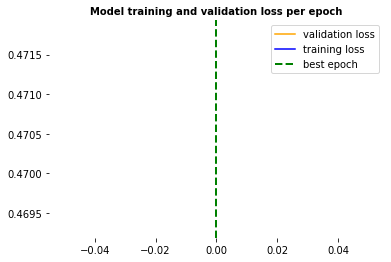

In [27]:
# fig, ax = plt.subplots()
# #fig.set_size_inches(30.5, 15.5)

# plt.plot(validation_losses,color='orange',label='validation loss')
# plt.plot(train_losses,color='blue',label='training loss')

# plt.axvline(x=best_epoch, color="green", linewidth=2, linestyle='dashed',label='best epoch')
# #plt.legend(['Val Loss', 'Train Loss', "Best Epoch"])
# plt.legend()

# # Hide the right and top spines
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

# plt.title("Model training and validation loss per epoch", fontsize=10, fontweight='bold')
# #plt.ylim(0.05,0.2)
# plt.savefig('/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img/1million_sageconv_hyp/GCNHYP_loss.png')
# plt.show()

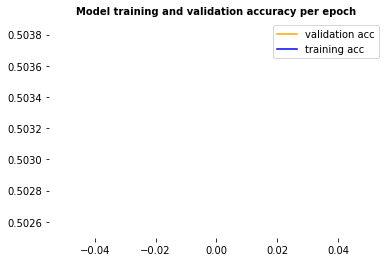

In [28]:
# fig, ax = plt.subplots()
# #fig.set_size_inches(30.5, 15.5)

# plt.plot(validation_accuracies,color='orange',label='validation acc')
# plt.plot(train_accuracies,color='blue',label='training acc')

# plt.legend()

# # Hide the right and top spines
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

# plt.title("Model training and validation accuracy per epoch", fontsize=10, fontweight='bold')
# #plt.ylim(0.05,0.2)
# plt.savefig('/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img/1million_sageconv_hyp/GCNHYP_acc.png')
# plt.show()

In [30]:
# best_model = torch.load("/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_pkl/1mill_ev_200epoch_hyp/best_model_sageconv4ly.pkl")
# best_model.to(device) 

# correct = 0
# total_samples = 0
# pred_test_cl=[]
# targets=[]
# with torch.no_grad():
#     for data in test_loader:
#         data = data.to(device)  
        
#         model_output = best_model(data)
#         predicted_class =  torch.where(model_output > 0.8, 1, 0)
#         pred_test_cl.extend(predicted_class.tolist())
#         correct += int((predicted_class == data.y).sum())
#         targets.extend(data.y.tolist())
#         total_samples += data.y.size(0)

# print('accuracy ',accuracy_score(targets,pred_test_cl),' recall ', recall_score(targets,pred_test_cl),' precision ',precision_score(targets,pred_test_cl))


accuracy  0.5023663157894737  recall  0.26915799432355725  precision  0.982550213578115
